# Memory task initial data exploration
## Matt Oberhardt



### Imports & API calls:

In [2]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
%matplotlib inline  
# from pandas import DataFrame, Series


In [3]:
# log in
def login_synapse(username, password):
    syn = synapseclient.Synapse()
    syn.login(username, password) # need to change this, security.
    return syn


# get the memory table up and running:
def load_memory_table_from_synapse(syn):
    memorysyn = syn.tableQuery("select * from %s" % 'syn5511434')
    memory = memorysyn.asDataFrame()

    # rename columns:
    memory.columns = [u'recordId', u'healthCode', u'createdOn',
        u'appVersion', u'phoneInfo', u'game_score',
        u'game_numGames', u'game_numFails', u'game_startDate',
        u'game_endDate', u'game_records', u'medTimepoint']

    # remove rows with null in the game_records column:
    memory = memory.dropna(subset=["game_records"])

    # Convert 'game_records' into a text key that matches filePaths:
    for rec in memory.game_records:
        assert (len(str(rec)) == 9), "records will not be parsed right since they are not the correct length - check %s" % rec
    memory['game_records_txt'] = memory.game_records.apply(lambda r: str(r)[:7])

    # finish:
    return memory, memorysyn


# get the demographics table up and running:
def load_demographics_table_from_synapse(syn):
    demosyn = syn.tableQuery("select * from %s" % 'syn5511429')
    demographics = demosyn.asDataFrame()

    # rename columns:
    demographics.columns = ([u'recordId_demographic', u'healthCode', u'createdOn_demographic', u'appVersion_demographic', u'phoneInfo_demographic',
       u'age', u'isCaretaker', u'brainStim', u'diagYear',
       u'education', u'employment', u'gender', u'healthHistory',
       u'healthcareProvider', u'homeUsage', u'lastSmoked', u'maritalStatus',
       u'medicalUsage', u'medicalUsageYesterday', u'medicationStartYear',
       u'onsetYear', u'packsPerDay', u'pastParticipation', u'phoneUsage',
       u'professionalDiagnosis', u'race', u'smartphone', u'smoked',
       u'surgery', u'videoUsage', u'yearsSmoking'])

    # finish:
    return demographics, demosyn


# get the json files (slow, only load from scratch once):
def load_memory_game_results_from_synapse(syn, memorysyn, fromScratch = False):
    if fromScratch:
        filePaths = syn.downloadTableColumns(memorysyn, u'MemoryGameResults.json.MemoryGameGameRecords')
        pickle.dump( filePaths, open( "filePaths_for_memory.p", "wb" ) )
    else:
        filePaths = pickle.load( open( "filePaths_for_memory.p", "rb" ) )
    return filePaths


# load in the json data for a memory test:
def load_memory_results_json(filePaths, game_record_txt):
#    with open(filePaths[u'5732386']) as data_file:
    with open(filePaths[game_record_txt]) as data_file:
        game_record = json.load(data_file)
    return game_record




### Load up the memory & demographic data:

In [4]:
## load in the data:

# logs in with credentials from os environment)
syn = login_synapse(os.environ['SYNAPSE_USER'], os.environ['SYNAPSE_PASS']) 

# load up tables:
memory, memorysyn = load_memory_table_from_synapse(syn)
filePaths = load_memory_game_results_from_synapse(syn, memorysyn)
demographics, demosyn = load_demographics_table_from_synapse(syn)
data = pd.merge(left=memory, right=demographics, how='inner', left_on='healthCode', right_on='healthCode')

# data is the main table, with memory and demographic data

Welcome, Matthew Oberhardt!


### Visualize the memory data:

#### Columns:

In [5]:
# columns:
for col in data.columns:
    print col

recordId
healthCode
createdOn
appVersion
phoneInfo
game_score
game_numGames
game_numFails
game_startDate
game_endDate
game_records
medTimepoint
game_records_txt
recordId_demographic
createdOn_demographic
appVersion_demographic
phoneInfo_demographic
age
isCaretaker
brainStim
diagYear
education
employment
gender
healthHistory
healthcareProvider
homeUsage
lastSmoked
maritalStatus
medicalUsage
medicalUsageYesterday
medicationStartYear
onsetYear
packsPerDay
pastParticipation
phoneUsage
professionalDiagnosis
race
smartphone
smoked
surgery
videoUsage
yearsSmoking


In [6]:
data.head(3)

,recordId,healthCode,createdOn,appVersion,phoneInfo,game_score,game_numGames,game_numFails,game_startDate,game_endDate,...,packsPerDay,pastParticipation,phoneUsage,professionalDiagnosis,race,smartphone,smoked,surgery,videoUsage,yearsSmoking
0,5a0b4204-8a6c-430f-be93-c5aa2d6c9e33,46f5740b-afa0-4432-94a4-4155ae963b75,1429652895000,"version 1.0.5, build 12",iPhone 6 Plus,400,5,0,1429652844000,1429652895000,...,NaN,False,true,False,"""Latino/Hispanic""",Very easy,False,False,True,NaN
1,0d313fd2-d798-4d09-8c21-b632c5ef454b,46f5740b-afa0-4432-94a4-4155ae963b75,1429912465000,"version 1.0.5, build 12",iPhone 6 Plus,285,5,1,1429912375000,1429912465000,...,NaN,False,true,False,"""Latino/Hispanic""",Very easy,False,False,True,NaN
2,4cfc9a04-9956-410c-a2e8-592b565aa305,64aedea6-b1f9-49da-8b10-3f02d8ed04b6,1429653765000,"version 1.0.5, build 12",iPhone 6,260,5,1,1429653708000,1429653765000,...,NaN,False,true,False,"""White or Caucasian""",Very easy,False,False,True,NaN


In [7]:
# summary stats:
data.describe()

,createdOn,game_score,game_numGames,game_numFails,game_startDate,game_endDate,game_records,createdOn_demographic,age,diagYear,lastSmoked,medicationStartYear,onsetYear,packsPerDay,yearsSmoking
count,7.981000e+03,7981.000000,7981.000000,7981.000000,7.981000e+03,7.981000e+03,7981.000000,7.981000e+03,7966.000000,6231.000000,2355.000000,6819.000000,6544.000000,2087.000000,2426.000000
mean,1.434635e+12,261.678988,4.996617,1.326651,1.434635e+12,1.434635e+12,5644469.313119,1.429334e+12,61.540673,2010.660889,1983.901911,1697.334507,2008.960880,1.176809,11.690025
std,3.626476e+09,59.984544,0.069827,0.581182,3.626477e+09,3.626475e+09,164683.766810,4.026537e+09,13.772669,3.699084,15.217572,729.861338,4.690024,0.389063,9.427551
min,1.429653e+12,0.000000,3.000000,0.000000,1.429653e+12,1.429653e+12,5413309.000000,1.425929e+12,18.000000,1976.000000,1959.000000,0.000000,1900.000000,1.000000,0.000000
25%,1.431271e+12,225.000000,5.000000,1.000000,1.431271e+12,1.431271e+12,5517020.000000,1.426032e+12,59.000000,2009.000000,1972.000000,2006.000000,2007.000000,1.000000,5.000000
50%,1.434057e+12,260.000000,5.000000,1.000000,1.434057e+12,1.434057e+12,5620601.000000,1.427230e+12,65.000000,2012.000000,1979.000000,2012.000000,2010.000000,1.000000,8.000000
75%,1.437578e+12,300.000000,5.000000,2.000000,1.437578e+12,1.437578e+12,5733201.000000,1.431799e+12,70.000000,2013.000000,1993.000000,2013.000000,2012.000000,1.000000,20.000000
max,1.441842e+12,400.000000,5.000000,4.000000,1.441841e+12,1.441842e+12,6959194.000000,1.441841e+12,90.000000,2015.000000,2015.000000,2015.000000,2015.000000,5.000000,50.000000


In [8]:
# separate to parkinsons and non parkinsons
def has_parkinsons(data):
    hasdiagyear = ~np.isnan(data.diagYear)
    hasprofessionalDiagnosis = data.professionalDiagnosis == True
    hasParkinsons = hasdiagyear | hasprofessionalDiagnosis
    return hasParkinsons

data['hasParkinsons'] = has_parkinsons(data)

# Dataset for Parkinson's patients
dPark = data[data.hasParkinsons == True] 
# Dataset for non-Parkinson's patients
dNon = data[data.hasParkinsons == False]

print 'The number of records with Parkinsons is %d' % len(dPark) # == sum(data['hasParkinsons'])
print 'The number of records without Parkinsons is %d' % len(dNon) # == sum(~data['hasParkinsons'])
print 'The total number of records is %d' % len(data)


The number of records with Parkinsons is 6263
The number of records without Parkinsons is 1718
The total number of records is 7981


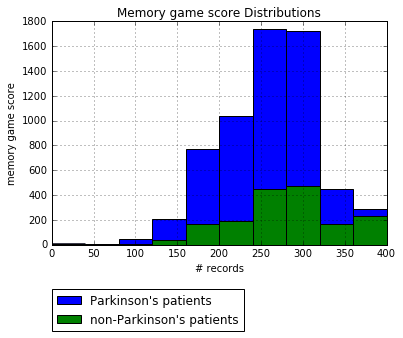

In [9]:
# plot the scores in Parkinsons and non-Parkinsons buckets
dPark.game_score.hist(label="Parkinson's patients")
dNon.game_score.hist(label="non-Parkinson's patients")
plt.title("Memory game score Distributions")
plt.ylabel('memory game score')
plt.xlabel('# records')
plt.legend(bbox_to_anchor=(0, -.2), loc=2, borderaxespad=0.)
pass


In [10]:
# ? distribution of # records per Parkinson's and non-Parkinson's patient


Phone type might affect the output..


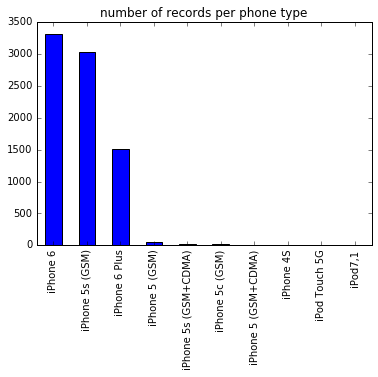

In [11]:
# look at how phone info affects results:
# (for parkinson's patients, &non?):

set(data.phoneInfo)
fig, ax = plt.subplots()
data.phoneInfo.value_counts().plot(ax=ax,kind='bar')
print('Phone type might affect the output..')
plt.title('number of records per phone type')
pass


In [12]:
# Filter out all but the most popular 3 phones:
#d2 = data[]
numuserscutoff = 1000
phonegroups = data.groupby('phoneInfo').size() 
goodphones = phonegroups[phonegroups > numuserscutoff].index
data = data[data.phoneInfo.isin(goodphones)]


Phone type might affect the output..


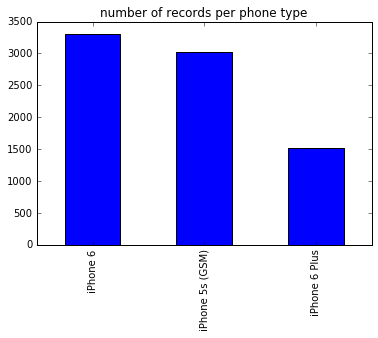

In [13]:
# Redo plot of how phone info affects results:
# (for parkinson's patients, &non?):

set(data.phoneInfo)
fig, ax = plt.subplots()
data.phoneInfo.value_counts().plot(ax=ax,kind='bar')
print('Phone type might affect the output..')
plt.title('number of records per phone type')
pass

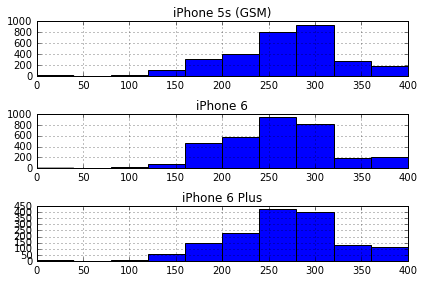

In [14]:
# todo check if the scores are different, within parkinson's category, for phone type!
#byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
#byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')
byphone = data.groupby('phoneInfo')

numphones = len(byphone)
allphones = byphone.phoneInfo.unique()
for n, phone in enumerate(allphones):
    plt.subplot(len(allphones),1,n+1)
    data.game_score[byphone.groups[phone[0]]].hist()
    plt.title(phone[0])

plt.tight_layout()




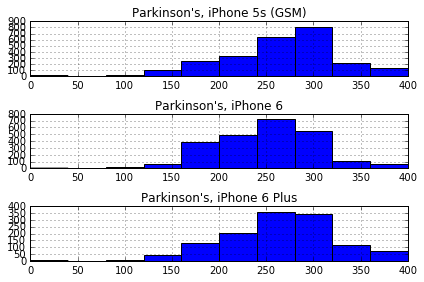

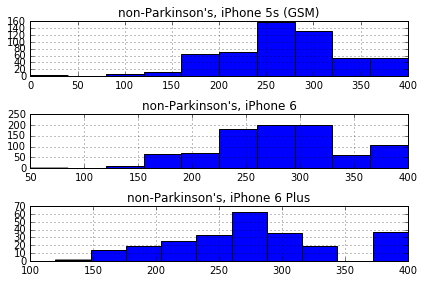

In [15]:
# compare these for parkinson's and non-parkinson's
# do on same plot too

# todo check if the scores are different, within parkinson's category, for phone type!
byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')

grouped = byphonePark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("Parkinson's, %s" % phone[0])
plt.tight_layout()

grouped = byphonenonPark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("non-Parkinson's, %s" % phone[0])
plt.tight_layout()


In [16]:
print data.head(3)

                               recordId                            healthCode  \
0  5a0b4204-8a6c-430f-be93-c5aa2d6c9e33  46f5740b-afa0-4432-94a4-4155ae963b75   
1  0d313fd2-d798-4d09-8c21-b632c5ef454b  46f5740b-afa0-4432-94a4-4155ae963b75   
2  4cfc9a04-9956-410c-a2e8-592b565aa305  64aedea6-b1f9-49da-8b10-3f02d8ed04b6   

       createdOn               appVersion      phoneInfo  game_score  \
0  1429652895000  version 1.0.5, build 12  iPhone 6 Plus         400   
1  1429912465000  version 1.0.5, build 12  iPhone 6 Plus         285   
2  1429653765000  version 1.0.5, build 12       iPhone 6         260   

   game_numGames  game_numFails  game_startDate   game_endDate      ...       \
0              5              0   1429652844000  1429652895000      ...        
1              5              1   1429912375000  1429912465000      ...        
2              5              1   1429653708000  1429653765000      ...        

   pastParticipation phoneUsage professionalDiagnosis            

In [ ]:
from sklearn import linear_model
import sklearn.linear_model
import sklearn.cross_validation

X = data['game_score']
Y = data['hasParkinsons'].astype('int')


X1 = X.as_matrix()
Y.tolist()

print X.__class__
print Y.__class__
print X1.__class__
print X1[:3]

logr = linear_model.LogisticRegression()
logr.fit( X1 , Y.tolist() )
#print logr


#print X.head(10)
#print Y.head(10)
#print sum(Y)
#print set(Y)
#print set(X)
#print len(X)
#print len(Y)



In [46]:
from sklearn import linear_model
import sklearn.linear_model
import sklearn.cross_validation
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples

features = ['game_score','game_numGames']
X = data[features]
#X = data['game_score']
Y = data['hasParkinsons'].astype('int')

logr = linear_model.LogisticRegression()

logr.fit( X , Y )


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:


# todo check if the scores are different, within parkinson's category, for phone type!
byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')


In [176]:
grouped = data.groupby('phoneInfo')


In [175]:
grouped.describe()

age     createdOn  createdOn_demographic  \
phoneInfo                                                                     
iPhone 4S           count     9.000000  9.000000e+00           9.000000e+00   
                    mean     66.444444  1.441555e+12           1.438221e+12   
                    std       0.527046  1.412197e+08           2.984945e+09   
                    min      66.000000  1.441347e+12           1.435704e+12   
                    25%      66.000000  1.441448e+12           1.435704e+12   
                    50%      66.000000  1.441587e+12           1.435704e+12   
                    75%      67.000000  1.441618e+12           1.441367e+12   
                    max      67.000000  1.441782e+12           1.441367e+12   
iPhone 5 (GSM)      count    54.000000  5.400000e+01           5.400000e+01   
                    mean     68.018519  1.441525e+12           1.426799e+12   
                    std       8.378974  2.038021e+08           2.489215e+09   
                    min      20.000000  1.441166e+12           1.426025e+12   
                    25%      70.000000  1.441379e+12           1.426111e+12   
                    50%      70.000000  1.441611e+12           1.426258e+12   
                    75%      70.000000  1.441663e+12           1.426258e+12   
                    max      77.000000  1.441842e+12           1.441841e+12   
iPhone 5 (GSM+CDMA) count    10.000000  1.000000e+01           1.000000e+01   
                    mean     64.800000  1.441559e+12           1.432170e+12   
                    std       8.991354  2.199649e+08           7.576582e+09   
                    min      47.000000  1.441209e+12           1.426029e+12   
                    25%      61.000000  1.441433e+12           1.426357e+12   
                    50%      61.000000  1.441619e+12           1.426357e+12   
                    75%      74.000000  1.441729e+12           1.440973e+12   
                    max      74.000000  1.441832e+12           1.440973e+12   
iPhone 5c (GSM)     count    24.000000  2.400000e+01           2.400000e+01   
                    mean     62.583333  1.441530e+12           1.434926e+12   
                    std       7.643791  1.881797e+08           6.708019e+09   
                    min      43.000000  1.441226e+12           1.426183e+12   
                    25%      61.000000  1.441391e+12           1.426183e+12   
                    50%      62.000000  1.441519e+12           1.438698e+12   
...                                ...           ...                    ...   
iPhone 6            std      14.592403  3.557042e+09           4.412280e+09   
                    min      18.000000  1.429654e+12           1.425929e+12   
                    25%      59.000000  1.431379e+12           1.426026e+12   
                    50%      68.000000  1.434330e+12           1.428064e+12   
                    75%      70.000000  1.437664e+12           1.433350e+12   
                    max      90.000000  1.441831e+12           1.441831e+12   
iPhone 6 Plus       count  1504.000000  1.517000e+03           1.517000e+03   
                    mean     60.308511  1.433826e+12           1.428831e+12   
                    std      11.933305  3.435155e+09           3.594705e+09   
                    min      18.000000  1.429653e+12           1.425930e+12   
                    25%      56.000000  1.430875e+12           1.425994e+12   
                    50%      63.000000  1.433079e+12           1.426987e+12   
                    75%      69.000000  1.436231e+12           1.430752e+12   
                    max      83.000000  1.441838e+12           1.441662e+12   
iPod Touch 5G       count     4.000000  4.000000e+00           4.000000e+00   
                    mean     63.500000  1.441565e+12           1.426849e+12   
                    std       7.000000  1.593025e+08           1.811788e+09   
                    min      60.000000  1.441399e+12           1.425943e+12   
      

In [179]:
grouped.agg({'game_score':'mean'})




,game_score
phoneInfo,
iPhone 4S,261.111111
iPhone 5 (GSM),306.666667
iPhone 5 (GSM+CDMA),217.000000
iPhone 5c (GSM),238.750000
iPhone 5s (GSM),264.919115
iPhone 5s (GSM+CDMA),293.125000
iPhone 6,256.364873
iPhone 6 Plus,265.336190
iPod Touch 5G,256.250000


In [180]:
data.head(3)

,recordId,healthCode,createdOn,appVersion,phoneInfo,game_score,game_numGames,game_numFails,game_startDate,game_endDate,...,pastParticipation,phoneUsage,professionalDiagnosis,race,smartphone,smoked,surgery,videoUsage,yearsSmoking,hasParkinsons
0,5a0b4204-8a6c-430f-be93-c5aa2d6c9e33,46f5740b-afa0-4432-94a4-4155ae963b75,1429652895000,"version 1.0.5, build 12",iPhone 6 Plus,400,5,0,1429652844000,1429652895000,...,False,true,False,"""Latino/Hispanic""",Very easy,False,False,True,NaN,False
1,0d313fd2-d798-4d09-8c21-b632c5ef454b,46f5740b-afa0-4432-94a4-4155ae963b75,1429912465000,"version 1.0.5, build 12",iPhone 6 Plus,285,5,1,1429912375000,1429912465000,...,False,true,False,"""Latino/Hispanic""",Very easy,False,False,True,NaN,False
2,4cfc9a04-9956-410c-a2e8-592b565aa305,64aedea6-b1f9-49da-8b10-3f02d8ed04b6,1429653765000,"version 1.0.5, build 12",iPhone 6,260,5,1,1429653708000,1429653765000,...,False,true,False,"""White or Caucasian""",Very easy,False,False,True,NaN,False


In [181]:
data.pivot_table(columns='phoneInfo')

phoneInfo,iPhone 4S,iPhone 5 (GSM),iPhone 5 (GSM+CDMA),iPhone 5c (GSM),iPhone 5s (GSM),iPhone 5s (GSM+CDMA),iPhone 6,iPhone 6 Plus,iPod Touch 5G,"iPod7,1"
age,6.644444e+01,6.801852e+01,6.480000e+01,6.258333e+01,6.172127e+01,3.491667e+01,6.199214e+01,6.030851e+01,6.350000e+01,5.800000e+01
createdOn,1.441555e+12,1.441525e+12,1.441559e+12,1.441530e+12,1.434684e+12,1.434632e+12,1.434748e+12,1.433826e+12,1.441565e+12,1.438021e+12
createdOn_demographic,1.438221e+12,1.426799e+12,1.432170e+12,1.434926e+12,1.428841e+12,1.433498e+12,1.429952e+12,1.428831e+12,1.426849e+12,1.437918e+12
diagYear,2.011111e+03,2.009708e+03,2.007400e+03,2.007208e+03,2.011683e+03,2.014000e+03,2.010242e+03,2.009544e+03,2.011500e+03,2.012000e+03
game_endDate,1.441555e+12,1.441525e+12,1.441559e+12,1.441530e+12,1.434684e+12,1.434632e+12,1.434748e+12,1.433826e+12,1.441565e+12,1.438021e+12
game_numFails,1.222222e+00,1.018519e+00,1.800000e+00,1.541667e+00,1.312644e+00,1.000000e+00,1.364571e+00,1.282136e+00,1.250000e+00,1.500000e+00
game_numGames,5.000000e+00,5.000000e+00,4.900000e+00,5.000000e+00,4.997029e+00,5.000000e+00,4.996070e+00,4.997363e+00,5.000000e+00,5.000000e+00
game_records,6.086385e+06,6.085755e+06,6.086640e+06,6.086366e+06,5.640585e+06,5.623280e+06,5.636195e+06,5.641218e+06,6.087078e+06,5.630180e+06
game_score,2.611111e+02,3.066667e+02,2.170000e+02,2.387500e+02,2.649191e+02,2.931250e+02,2.563649e+02,2.653362e+02,2.562500e+02,2.900000e+02
game_startDate,1.441555e+12,1.441524e+12,1.441559e+12,1.441530e+12,1.434683e+12,1.434631e+12,1.434748e+12,1.433826e+12,1.441565e+12,1.438021e+12


In [177]:
grouped.sum()





,createdOn,game_score,game_numGames,game_numFails,game_startDate,game_endDate,game_records,createdOn_demographic,age,diagYear,lastSmoked,medicationStartYear,onsetYear,packsPerDay,yearsSmoking,hasParkinsons
phoneInfo,,,,,,,,,,,,,,,,
iPhone 4S,12973997032000,2350,45,11,12973996394000,12973996950000,54777467,12943988975000,598,18100,9915,18130,18088,5,75,9
iPhone 5 (GSM),77842324329000,16560,270,55,77842320710000,77842324153000,328630780,77047131796000,3673,96466,65215,88406,106499,33,217,48
iPhone 5 (GSM+CDMA),14415588948000,2170,49,18,14415588320000,14415588898000,60866397,14321704836000,648,20074,7900,18062,20064,4,48,10
iPhone 5c (GSM),34596730750000,5730,120,37,34596729223000,34596730678000,146072783,34438233508000,1502,48173,25960,46172,48040,13,307,24
iPhone 5s (GSM),4345656464767000,802440,15136,3976,4345656257976000,4345656464483000,17085332023,4327960835677000,186892,4995009,2115257,4432639,5008728,1270,13802,2483
iPhone 5s (GSM+CDMA),34431156301000,7035,120,24,34431155022000,34431156301000,134958708,34403953320000,838,4028,4005,2015,4029,1,14,2
iPhone 6,4746147732850000,848055,16527,4514,4746147513717000,4746147732591000,18644534434,4730280302328000,205008,4846693,1747704,4498022,5344607,772,11704,2411
iPhone 6 Plus,2175114785124000,402515,7581,1945,2175114687377000,2175114784995000,8557728322,2167537258451000,90704,2487815,690199,2458601,2584536,358,2184,1270
iPod Touch 5G,5766261824000,1025,20,5,5766261547000,5766261806000,24348313,5707396451000,254,8046,5934,8047,8023,NaN,9,4


In [170]:
# todo check if the scores are different, within parkinson's category, for phone type!
byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')

        
#phones = ['iPhone 6', 'iPhone 5s (GSM)', 'iPhone 6 Plus']
## phones_unique = byphonePark.phoneInfo.unique()
#ax = {}
#
#fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
#
#for phone in phones:
#    ax[phone].hist(byphonePark.game_score, label=phone)
#    


#allphones = byphonePark.phoneInfo.unique()
allphones = ['iPhone 6']
for phone in allphones:
#    print phone
    temp = byphonePark[byphonePark.phoneInfo==phone]
    
#    temp = byphonePark[byphonePark.phoneInfo==phone]
    
#    plt.hist(temp.game_score, label=phone)    
#plt.legend()
#plt.show()
                       
                       
                       
#for phone in phones_of_interest:
#    temp = byphonePark[byphonePark.phoneInfo==phone]
#    plt.hist(temp.game_score, label=phone)
#    
#plt.legend()
#plt.show()



## look up subplots


#for phonetype, phonedata in byphonePark:
#    phonedata.game_score.hist(label=phonetype)
#    print phonedata.game_score
    
#    plt.hist(phonedata.game_score, label = phonetype)
#plt.legend()
#plt.show()

#for ind, phonetype in enumerate(byphonePark):
#    plt
#    d = 
#    plt.plot()
#
#    datacurr.game_score.hist()

    
    
#data[data.hasParkinsons==True].game_score.hist(label="Parkinson's patients")
#data[data.hasParkinsons==False].game_score.hist(label="non-Parkinson's patients")
#
#plt.title("Memory game score Distributions")
#plt.ylabel('memory game score')
#plt.xlabel('# records')
#plt.legend(bbox_to_anchor=(0, -.2), loc=2, borderaxespad=0.)

#pass

In [45]:
byphonePark.groups







{'iPhone 5s (GSM)': [131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
 

In [ ]:
# look at, per patient, the records w/ different 'when took medicine' stats

In [36]:
# game_scores for Parkinson's vs non

for m in med_timepoint: 
    print m
    
doctor diagnosis & diagnosis year

for     diagYear   
    professionalDiagnosis
    
    
    

nan
I don't take Parkinson medications
Immediately before Parkinson medication
Another time
Just after Parkinson medication (at your best)


### Split into Parkinson's patients and non-patients

In [29]:
# the definitely parkinson's ones will have 
data.columns

memory[col_name] = data.events.apply(lambda e: event_kind in e)
   

Index([        u'recordId',       u'healthCode',        u'createdOn',
             u'appVersion',        u'phoneInfo',       u'game_score',
          u'game_numGames',    u'game_numFails',   u'game_startDate',
           u'game_endDate',     u'game_records',     u'medTimepoint',
       u'game_records_txt'],
      dtype='object')

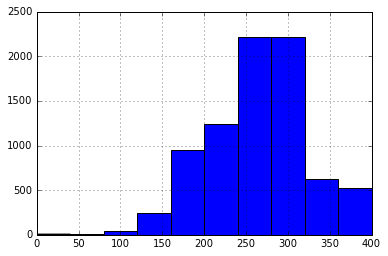

In [30]:
memory.game_score.hist()